In [1]:
from ax import Client, RangeParameterConfig, ChoiceParameterConfig

from ax.analysis.analysis import (
    Analysis,   
    AnalysisCard,
    AnalysisCardCategory,
    AnalysisCardLevel,
)

from ax.generation_strategy.model_spec import GeneratorSpec
from ax.modelbridge.registry import Generators

from gpytorch.kernels import MaternKernel
from botorch.models import SingleTaskGP
from botorch.models.transforms.input import Warp
from botorch.models.map_saas import AdditiveMapSaasSingleTaskGP
from ax.utils.stats.model_fit_stats import MSE
from ax.models.torch.botorch_modular.surrogate import SurrogateSpec, ModelConfig, Surrogate

from ax.analysis.plotly.parallel_coordinates import ParallelCoordinatesPlot
from ax.analysis.plotly.surface.slice import SlicePlot

from botorch.acquisition.logei import qLogNoisyExpectedImprovement, qLogExpectedImprovement

import pandas as pd
import numpy as np
from scipy.stats import qmc
import random
import pickle

import matplotlib.pyplot as plt
import scienceplots

from utils import score_vals, param_to_list, list_to_param, combine_meta_test, df_to_sv, validate_parameters, construct_generation_strategy, add_trials, df_for_new_trials

# Mute warnings:
import warnings
warnings.filterwarnings('ignore')

## Generation Strategy - set up to go directly to BayZop
#### https://ax.dev/docs/tutorials/modular_botorch/

In [2]:
GENERATION_SET = False

In [3]:
surrogate_spec = SurrogateSpec(
    model_configs=[
        # Select between two models:
        # An additive mixture of relatively strong SAAS priors with input Warping.
        # A relatively vanilla GP with a Matern kernel.
        ModelConfig(
            botorch_model_class=AdditiveMapSaasSingleTaskGP, # maximum-a-posteriori, sparse axis-aligned subspace 
            input_transform_classes=[Warp],
        ),
        ModelConfig(
            botorch_model_class=SingleTaskGP, # maximize a single score (should this be mixedsingletaskgp?)
            covar_module_class=MaternKernel, # Matern kernel
            covar_module_options={"nu": 2.5}, # 'The smoothness parameter for the Matern kernel: either 1/2, 3/2, or 5/2.'
        ),
    ],
    eval_criterion=MSE,  # Select the model to use as the one that minimizes mean squared error.
    allow_batched_models=False,  # Forces each metric to be modeled with an independent BoTorch model.
)

In [4]:
# setup generation strategy

generator_spec = GeneratorSpec(
    model_enum=Generators.BOTORCH_MODULAR,
    model_kwargs={
        "surrogate_spec": surrogate_spec, # set up above (MAP SAAS Single GP)
        "botorch_acqf_class": qLogNoisyExpectedImprovement, # Expected Improvement - based acquisition (https://arxiv.org/abs/2310.20708)
        # "botorch_acqf_class": qLogExpectedImprovement # see if this works for categorical inputs
    },
    # We can specify various options for the optimizer here - LEFT AS DEFAULT
    model_gen_kwargs = {
        "model_gen_options": {
            "optimizer_kwargs": {
                "num_restarts": 20,
                # "sequential": False,
                "sequential": True, # to work with acquisition function on categorical
                "options": {
                    "batch_limit": 5,
                    # "maxiter": 200,
                    "maxiter_init": 200, # to work with sequential
                },
            },
        },
    }
)

generation_strategy = construct_generation_strategy(
    generator_spec=generator_spec, # set up above (surrogate w/ EI & standard kwargs)
    node_name="BoTorch w/ Model Selection",
)
generation_strategy

GenerationStrategy(name='Sobol+BoTorch w/ Model Selection', nodes=[GenerationNode(node_name='Sobol', model_specs=[GeneratorSpec(model_enum=Sobol, model_key_override=None)], transition_criteria=[MinTrials(transition_to='BoTorch w/ Model Selection')]), GenerationNode(node_name='BoTorch w/ Model Selection', model_specs=[GeneratorSpec(model_enum=BoTorch, model_key_override=None)], transition_criteria=[])])

## Initialize our Ax Client

In [5]:
Tag_client = Client()

In [6]:
Tag_client._random_seed = 237
# provide repeatability

In [7]:
# Define bounds for each parameter type
int_bounds = {
    "z_sh": [6, 9], #NOTE - z_sh is half z_s (which must be even)
    # "z_r2": [70, 86],
    "z_r2": [76, 85],
    "g_thickness_h": [3, 6], #NOTE - half of actual gear thickness [mm]
    "p1_offset": [-1,2],
    "p2_offset": [-1,2],
}

choice_bounds = {
    "material": ['PLA', 'ABS'], #PLA, ABS
    "lubricant": ['None', 'LI', 'Oil', 'PTFE'], #Nonte, LI, Oil, PTFE
}

float_bounds = {
    "x_s": [-0.8, 0.8],
    "x_r2": [-.25, 1.],
    "Cl": [0,0.0003]
}

# Generate parameters dynamically
parameters = []

# Add integer parameters
for name, bounds in int_bounds.items():
    lower, upper = bounds
    this_param = RangeParameterConfig(
        name = name,
        bounds = (lower, upper),  # adjust bounds to deal with order
        parameter_type = "int",
        )
    parameters.append(this_param)


# Add float parameters
for name, bounds in float_bounds.items():
    lower, upper = bounds
    this_param = RangeParameterConfig(
        name = name,
        bounds = (lower, upper),  # adjust bounds to deal with order
        parameter_type = "float",
        )
    parameters.append(this_param)

# Add choice parameters
for name, vals in choice_bounds.items():
    this_param = ChoiceParameterConfig(
        name = name,
        values = vals,
        parameter_type= "str",
    )
    parameters.append(this_param)

# Create the experiment
Tag_client.configure_experiment(
    parameters=parameters,
)

In [8]:
Tag_client.configure_optimization(objective="Max_torque_gear_ratio_product", outcome_constraints=["gear_ratio >= 1"] )

In [9]:
# Update the generation strategy (see section above)
Tag_client.set_generation_strategy(
    generation_strategy=generation_strategy,
)
GENERATION_SET = True

## Grab data from Taguchi array trials - initialize client

In [10]:
Tag_tests = pd.read_pickle('Taguchi_test_dict.pkl') # All 32 Taguchi tests
Tag_meta = pd.read_csv('Tag_d_params.csv') # Meta data for Taguchi tests
tested_df = combine_meta_test(Tag_meta, Tag_tests)
tested_df = tested_df.dropna(subset=['max_current']) # Remove any incomplete tests
sv_out = df_to_sv(tested_df) # 'in_vals' for Taguchi tests

In [11]:
seed = 116
# number of initial trials to add (somewhat arbitrary, balance between sufficiently spanning and hopefully not too interested in local minima)
Number_of_initialization_trials = 10

random.seed(seed)
# choose 10 random numbers between 0 and 31
choices = random.sample(range(0, 32), Number_of_initialization_trials)

In [12]:
init_df = tested_df.iloc[choices]

# Get indices of rows we want to keep (those not in init_df)
remaining_indices = tested_df.index.difference(init_df.index)

# Create new DataFrame with remaining rows
remaining_df = tested_df.loc[remaining_indices]

# arrange by design number
init_df = init_df.sort_values(by='Design')
remaining_df = remaining_df.sort_values(by='Design')
init_df

,Design,material,lubricant,z_sh,z_r2,x_s,x_r2,Cl,g_thickness_h,p1_offset,p2_offset,gear_ratio,max_current,max_dxt
0,1,PLA,NaN,6,76,-0.8,-0.25,0.0000,3,-1,-1,53.598253,1032.500,0.964809
3,4,PLA,NaN,9,85,0.5,1.00,0.0003,6,2,2,102.000000,1066.150,0.964809
4,5,PLA,LI,6,76,-0.5,0.00,0.0002,5,2,2,52.343874,192.500,0.171398
7,8,PLA,LI,9,85,0.0,0.50,0.0001,4,-1,-1,216.750000,1146.625,0.964809
15,16,PLA,PTFE,9,83,-0.8,0.00,0.0001,3,1,2,1675.090909,977.000,0.964809
19,20,ABS,NaN,9,76,0.5,-0.25,0.0002,4,1,0,24.648649,283.750,0.297996
20,21,ABS,LI,6,85,-0.5,0.50,0.0003,3,1,0,1878.500000,1094.375,0.964809
23,24,ABS,LI,9,76,0.0,0.00,0.0000,6,0,1,33.777778,483.250,0.642473
24,25,ABS,Oil,6,83,0.0,-0.25,0.0001,6,2,0,108.538461,1068.750,0.964809
29,30,ABS,PTFE,7,85,0.0,-0.25,0.0002,3,0,2,245.924812,1075.000,0.964809


In [13]:
param_names = [parameters[x].name for x in range(len(parameters))]
# Add initial trials
add_trials(Tag_client, tested_df, param_names, choice_bounds, int_bounds, inds = choices)

In [14]:
# Summary of initialization
Tag_client.summarize()

,trial_index,arm_name,trial_status,gear_ratio,Max_torque_gear_ratio_product,z_sh,z_r2,g_thickness_h,p1_offset,p2_offset,x_s,x_r2,Cl,material,lubricant
0,0,0_0,COMPLETED,24.648649,8.271467e+01,9,76,4,1,0,0.5,-0.25,0.0002,ABS,None
1,1,1_0,COMPLETED,53.598253,5.359825e-11,6,76,3,-1,-1,-0.8,-0.25,0.0000,PLA,None
2,2,2_0,COMPLETED,108.538461,1.085385e-10,6,83,6,2,0,0.0,-0.25,0.0001,ABS,Oil
3,3,3_0,COMPLETED,1500.000000,1.500000e-09,6,85,3,1,0,-0.5,0.50,0.0003,ABS,LI
4,4,4_0,COMPLETED,102.000000,1.020000e-10,9,85,6,2,2,0.5,1.00,0.0003,PLA,None
5,5,5_0,COMPLETED,33.777778,5.257462e+01,9,76,6,0,1,0.0,0.00,0.0000,ABS,LI
6,6,6_0,COMPLETED,52.343874,3.053940e+02,6,76,5,2,2,-0.5,0.00,0.0002,PLA,LI
7,7,7_0,COMPLETED,1500.000000,1.500000e-09,9,83,3,1,2,-0.8,0.00,0.0001,PLA,PTFE
8,8,8_0,COMPLETED,245.924812,2.459248e-10,7,85,3,0,2,0.0,-0.25,0.0002,ABS,PTFE
9,9,9_0,COMPLETED,216.750000,2.167500e-10,9,85,4,-1,-1,0.0,0.50,0.0001,PLA,LI


## Begin Bayesian Optimization Trials

### Load previously completed BO trials - add them to the Client

In [15]:
# load meta and test data for BO designs
BO_meta_file = 'BO_designs/BO_d_params.csv' #.csv
BO_test_file = 'BayzOp_test_dict.pkl' #.pkl
# BO_test_file = 'badfile'

design_order = ['index','z_s', 'z_p1', 'z_p2', 'z_r2', 'xs', 'xp1', 'xp2', 'xr2', 'r_a', 'thickness', 'Cl', 'material', 'lubricant']
meta_order = ['Design','material','lubricant','z_sh','z_r2','x_s','x_r2','Cl','g_thickness_h','p1_offset','p2_offset','gear_ratio']
BO_meta_exist = True
try:
    BO_d_params = pd.read_csv(BO_meta_file) # all BO designs
except:
    BO_d_params = pd.DataFrame(columns=meta_order)
    BO_meta_exist = False
    print('No existing design file found. Creating new one.')
    
# grab the experimental output for the new designs
BO_tests_exist = True
try:
    BO_tests = pd.read_pickle(BO_test_file)
except:
    BO_tests = {}
    BO_tests_exist = False
    print('No existing test file found. Creating new one.')

In [16]:
BO_d_params

,Design,material,lubricant,z_sh,z_r2,x_s,x_r2,Cl,g_thickness_h,p1_offset,p2_offset,gear_ratio
0,10,ABS,LI,7,77,-0.357144,0.760397,3.000000e-04,6,2,2,104.732394
1,11,ABS,NaN,8,76,-0.401274,0.063233,3.000000e-04,6,2,-1,26.281593
2,12,PLA,PTFE,6,76,0.389719,0.252311,7.012641e-06,3,1,2,71.169492
3,13,ABS,LI,9,76,0.796491,-0.108898,3.000000e-04,6,1,2,38.926829
4,14,ABS,LI,7,79,0.651174,-0.166665,0.000000e+00,3,0,0,53.880184
5,15,PLA,LI,6,76,-0.648760,0.441726,6.337800e-05,3,2,1,63.668269
6,16,PLA,LI,6,76,0.331754,0.567660,3.000000e-04,6,2,1,56.743243
7,17,PLA,LI,6,76,-0.800000,0.787381,2.978554e-08,6,2,2,112.228814
8,18,ABS,LI,6,76,0.249718,-0.250000,5.055807e-05,3,2,2,49.692308
9,19,PLA,NaN,6,76,0.053514,-0.093661,1.636058e-04,3,-1,2,118.326733


In [17]:
Incomplete = False
if BO_tests_exist and BO_meta_exist:
    prev_BO_df = combine_meta_test(BO_d_params, BO_tests) # combine meta and test data
    if np.isnan(prev_BO_df['max_current']).any():
        print('Incomplete tests found.')
        Incomplete = True

In [18]:
# add previoius BO trials to this Ax run (if they exist)
if 'prev_BO_df' in locals():
    add_trials(Tag_client, prev_BO_df, param_names, choice_bounds, int_bounds)

In [19]:
Tag_client.summarize()

,trial_index,arm_name,trial_status,gear_ratio,Max_torque_gear_ratio_product,z_sh,z_r2,g_thickness_h,p1_offset,p2_offset,x_s,x_r2,Cl,material,lubricant
0,0,0_0,COMPLETED,24.648649,8.271467e+01,9,76,4,1,0,0.500000,-0.250000,2.000000e-04,ABS,None
1,1,1_0,COMPLETED,53.598253,5.359825e-11,6,76,3,-1,-1,-0.800000,-0.250000,0.000000e+00,PLA,None
2,2,2_0,COMPLETED,108.538461,1.085385e-10,6,83,6,2,0,0.000000,-0.250000,1.000000e-04,ABS,Oil
3,3,3_0,COMPLETED,1500.000000,1.500000e-09,6,85,3,1,0,-0.500000,0.500000,3.000000e-04,ABS,LI
4,4,4_0,COMPLETED,102.000000,1.020000e-10,9,85,6,2,2,0.500000,1.000000,3.000000e-04,PLA,None
5,5,5_0,COMPLETED,33.777778,5.257462e+01,9,76,6,0,1,0.000000,0.000000,0.000000e+00,ABS,LI
6,6,6_0,COMPLETED,52.343874,3.053940e+02,6,76,5,2,2,-0.500000,0.000000,2.000000e-04,PLA,LI
7,7,7_0,COMPLETED,1500.000000,1.500000e-09,9,83,3,1,2,-0.800000,0.000000,1.000000e-04,PLA,PTFE
8,8,8_0,COMPLETED,245.924812,2.459248e-10,7,85,3,0,2,0.000000,-0.250000,2.000000e-04,ABS,PTFE
9,9,9_0,COMPLETED,216.750000,2.167500e-10,9,85,4,-1,-1,0.000000,0.500000,1.000000e-04,PLA,LI


In [20]:
best_parameters, prediction, index, name = Tag_client.get_best_parameterization()
print("Best Parameters:", best_parameters)
print("Prediction (mean, variance):", prediction)

Best Parameters: {'z_sh': 6, 'z_r2': 80, 'g_thickness_h': 3, 'p1_offset': 2, 'p2_offset': -1, 'x_s': -0.8, 'x_r2': 0.543704837498592, 'Cl': 0.0003, 'material': 'PLA', 'lubricant': 'None'}
Prediction (mean, variance): {'Max_torque_gear_ratio_product': (403.14872035529834, nan), 'gear_ratio': (56.89795918367346, nan)}


# Find next 2 BO tests - add design values to BO_d_params

In [21]:
# check to see if we're done with BO (32 completed tests)
if len(Tag_client.summarize()) >= 32:
    print("BO is complete. No more trials will be added.")
    Incomplete = True

BO is complete. No more trials will be added.


In [ ]:
if Incomplete:
    raise RuntimeError('Incomplete tests found. Please complete all tests before proceeding.')

In [ ]:
trials = Tag_client.get_next_trials(max_trials=2)
for key in trials:
    trial = trials[key]
    meta_order = ['Design','material','lubricant','z_sh','z_r2','x_s','x_r2','Cl','g_thickness_h','p1_offset','p2_offset','gear_ratio']
    # start pd with meta_order as columns
    new_trial = pd.DataFrame(columns=meta_order)
    for column in meta_order:
        if column in trial.keys():
            new_trial[column] = trial[column]
    # add design and gear_ratio columns
    new_trial['Design'] = key
    
trial

{'z_sh': 6,
 'z_r2': 76,
 'g_thickness_h': 3,
 'p1_offset': 2,
 'p2_offset': -1,
 'x_s': -0.7458585858345033,
 'x_r2': 0.9918944019348123,
 'Cl': 0.00029295614797768943,
 'material': 'ABS',
 'lubricant': 'PTFE'}

In [ ]:
new_design_vals_df, new_meta_vals_df = df_for_new_trials(trials, meta_order, design_order)

In [23]:
Tag_client.summarize()

,trial_index,arm_name,trial_status,gear_ratio,Max_torque_gear_ratio_product,z_sh,z_r2,g_thickness_h,p1_offset,p2_offset,x_s,x_r2,Cl,material,lubricant
0,0,0_0,COMPLETED,24.648649,8.271467e+01,9,76,4,1,0,0.500000,-0.250000,2.000000e-04,ABS,None
1,1,1_0,COMPLETED,53.598253,5.359825e-11,6,76,3,-1,-1,-0.800000,-0.250000,0.000000e+00,PLA,None
2,2,2_0,COMPLETED,108.538461,1.085385e-10,6,83,6,2,0,0.000000,-0.250000,1.000000e-04,ABS,Oil
3,3,3_0,COMPLETED,1500.000000,1.500000e-09,6,85,3,1,0,-0.500000,0.500000,3.000000e-04,ABS,LI
4,4,4_0,COMPLETED,102.000000,1.020000e-10,9,85,6,2,2,0.500000,1.000000,3.000000e-04,PLA,None
5,5,5_0,COMPLETED,33.777778,5.257462e+01,9,76,6,0,1,0.000000,0.000000,0.000000e+00,ABS,LI
6,6,6_0,COMPLETED,52.343874,3.053940e+02,6,76,5,2,2,-0.500000,0.000000,2.000000e-04,PLA,LI
7,7,7_0,COMPLETED,1500.000000,1.500000e-09,9,83,3,1,2,-0.800000,0.000000,1.000000e-04,PLA,PTFE
8,8,8_0,COMPLETED,245.924812,2.459248e-10,7,85,3,0,2,0.000000,-0.250000,2.000000e-04,ABS,PTFE
9,9,9_0,COMPLETED,216.750000,2.167500e-10,9,85,4,-1,-1,0.000000,0.500000,1.000000e-04,PLA,LI


In [ ]:
# Look at latest surrogate
cards = Tag_client.compute_analyses(display=False)

## Adding next-test details to dataframes still under construction

In [36]:
# Update d_params with meta data
try:
    test_BO = pd.concat([BO_d_params, new_meta_vals_df], axis=0)
except:
    test_BO = BO_d_params

# check if any Design numbers repeat
designs = test_BO['Design'].unique()
if len(designs) != len(test_BO):
    raise RuntimeError('Design numbers repeat. Do not overwrite trials!')
else:
    try:
        BO_meta = pd.concat([BO_d_params, new_meta_vals_df], axis=0)
    except:
        BO_meta = test_BO

In [ ]:
BO_meta.to_csv(BO_meta_file, index=False) # save to csv

In [37]:
BO_experimental = combine_meta_test(BO_meta, BO_tests)

In [ ]:
# save into the running csv file in a folder \BO_designs\\
if not Incomplete:
    new_keys = [x for x in trials.keys()]
    new_design_vals_df.to_csv(f'BO_designs/trial_{new_keys}_d_vals.csv', index=False)

## Taguchi Data Single-Shot Optimization

In [25]:
# One-Shot Client
OS_client = Client()
OS_client._random_seed = 237

OS_client.configure_experiment(
    parameters=parameters,
)
OS_client.configure_optimization(objective="Max_torque_gear_ratio_product", outcome_constraints=["gear_ratio >= 1"] )
# OS_client.set_generation_strategy(
#     generation_strategy=generation_strategy,
# )

In [26]:
OS_client.configure_generation_strategy(
    # Reduce or skip the initialization step
    # NOTE: Don't set this to 0 (which would skip initialization) unless you
    # attached manual trials. It's not possible to fully skip the initialization
    # step and start Bayesian optimization without any completed trials with data!
    initialization_budget=0,
    # Do not use center of searchspace as the first point
    initialize_with_center=False,
    # Allow for exceeding the provided initialization budget
    allow_exceeding_initialization_budget=True,
    # Don't count manually added trials against the initialization
    # budget (i.e. ensure that the 3 quasi-random Sobol trials will
    # be run, e.g. to sample the search space more evenly).
    use_existing_trials_for_initialization=True,
)

In [27]:
# Add ALL Taguchi trials
add_trials(OS_client, tested_df, param_names, choice_bounds, int_bounds)

In [28]:
OS_client.summarize()

,trial_index,arm_name,trial_status,gear_ratio,Max_torque_gear_ratio_product,z_sh,z_r2,g_thickness_h,p1_offset,p2_offset,x_s,x_r2,Cl,material,lubricant
0,0,0_0,COMPLETED,53.598253,5.359825e-11,6,76,3,-1,-1,-0.8,-0.25,0.0000,PLA,None
1,1,1_0,COMPLETED,115.480519,1.154805e-10,7,81,4,0,0,-0.5,0.00,0.0001,PLA,None
2,2,2_0,COMPLETED,1500.000000,1.500000e-09,8,83,5,1,1,0.0,0.50,0.0002,PLA,None
3,3,3_0,COMPLETED,102.000000,1.020000e-10,9,85,6,2,2,0.5,1.00,0.0003,PLA,None
4,4,4_0,COMPLETED,52.343874,3.053940e+02,6,76,5,2,2,-0.5,0.00,0.0002,PLA,LI
5,5,5_0,COMPLETED,84.110599,1.321231e+02,7,81,6,1,1,-0.8,-0.25,0.0003,PLA,LI
6,6,6_0,COMPLETED,274.937500,2.749375e-10,8,83,3,0,0,0.5,1.00,0.0000,PLA,LI
7,7,7_0,COMPLETED,216.750000,2.167500e-10,9,85,4,-1,-1,0.0,0.50,0.0001,PLA,LI
8,8,8_0,COMPLETED,1500.000000,1.500000e-09,6,81,4,1,2,0.0,1.00,0.0000,PLA,Oil
9,9,9_0,COMPLETED,49.590734,4.959073e-11,7,76,3,2,1,0.5,0.50,0.0001,PLA,Oil


In [29]:
# Generate next trial (Single-Shot BO)
trials = OS_client.get_next_trials(max_trials=1)

In [30]:
best_parameters, prediction, index, name = OS_client.get_best_parameterization()
print("Best Parameters:", best_parameters)
print("Prediction (mean, variance):", prediction)

Best Parameters: {'z_sh': 6, 'z_r2': 76, 'g_thickness_h': 5, 'p1_offset': 2, 'p2_offset': 2, 'x_s': -0.5, 'x_r2': 0.0, 'Cl': 0.0002, 'material': 'PLA', 'lubricant': 'LI'}
Prediction (mean, variance): {'gear_ratio': (52.46127701415458, 23.384815775218993), 'Max_torque_gear_ratio_product': (303.8337104793634, 34.6700307834334)}


In [31]:
OneShot_design_df, OneShot_meta_df = df_for_new_trials(trials, meta_order, design_order)

In [32]:
cards = OS_client.compute_analyses(display=False)

In [33]:
OneShot_design_df.to_csv(f'BO_designs/BO_OneShot_d_vals.csv', index=False)
OneShot_meta_df.to_csv(f'BO_designs/BO_OneShot_meta_vals.csv', index=False)

## All data single shot optimization

In [38]:
# omnipotent client
Omnipotent_client = Client()
Omnipotent_client._random_seed = 237

Omnipotent_client.configure_experiment(
    parameters=parameters,
)
Omnipotent_client.configure_optimization(objective="Max_torque_gear_ratio_product", outcome_constraints=["gear_ratio >= 1"] )
Omnipotent_client.set_generation_strategy(
    generation_strategy=generation_strategy,
)

add_trials(Omnipotent_client, tested_df, param_names, choice_bounds, int_bounds)
add_trials(Omnipotent_client, BO_experimental[np.isfinite(BO_experimental['max_current'])], param_names, choice_bounds, int_bounds)

omn_trial = Omnipotent_client.get_next_trials(max_trials=1)

In [39]:
omn_design_vals_df, omn_meta_vals_df = df_for_new_trials(omn_trial, meta_order, design_order)

In [40]:
omn_design_vals_df

,index,z_s,z_p1,z_p2,z_r2,xs,xp1,xp2,xr2,r_a,thickness,Cl,material,lubricant
0,54,12.0,40.0,26.0,76,-0.3089,-0.7169,0.9762,0.2746,0.0203,10,0.000297,ABS,PTFE


In [41]:
omn_design_vals_df.to_csv(f'BO_designs/BO_All_OneShot_d_vals.csv', index=False)
omn_meta_vals_df.to_csv(f'BO_designs/BO_All_OneShot_meta_vals.csv', index=False)

## Find posterier Standard Error and Relative Error from holdout Taguchi Vals.
#### This function takes an Ax client and a list of parameter dicts, and returns the posterior mean and standard deviation for each input using the current BoTorch model.

In [42]:
test_param_dict = [{"z_sh": 7, "z_r2": 80, "g_thickness_h": 4, "p1_offset": 0, "p2_offset": 1, "x_s": 0.0, "x_r2": 0.0, "Cl": 0.0001, "material": "PLA", "lubricant": "None"}]

In [43]:
# Tag_check_client
Tag_check_client = Client()
Tag_check_client._random_seed = 237

Tag_check_client.configure_experiment(
    parameters=parameters,
)
Tag_check_client.configure_optimization(objective="Max_torque_gear_ratio_product", outcome_constraints=["gear_ratio >= 1"] )
Tag_check_client.set_generation_strategy(
    generation_strategy=generation_strategy,
)

add_trials(Tag_check_client, tested_df, param_names, choice_bounds, int_bounds, inds = list(range(0,10)))


In [44]:
# BO_check_client
BO_check_client = Client()
BO_check_client._random_seed = 237

BO_check_client.configure_experiment(
    parameters=parameters,
)
BO_check_client.configure_optimization(objective="Max_torque_gear_ratio_product", outcome_constraints=["gear_ratio >= 1"] )
BO_check_client.set_generation_strategy(
    generation_strategy=generation_strategy,
)

add_trials(BO_check_client, tested_df, param_names, choice_bounds, int_bounds, inds = choices)

In [45]:
# Tag_client.predict(param_dicts)

In [46]:
# set up a grid of parameter dictionaries (latin hypercube of size n=40)

# Set up parameter bounds
int_params = ['z_sh', 'z_r2', 'g_thickness_h', 'p1_offset', 'p2_offset']
int_bounds = {
    "z_sh": [6, 9],
    "z_r2": [76, 85], 
    "g_thickness_h": [3, 6],
    "p1_offset": [-1, 2],
    "p2_offset": [-1, 2],
}

float_params = ['x_s', 'x_r2', 'Cl']
float_bounds = {
    "x_s": [-0.8, 0.8],
    "x_r2": [-.25, 1.],
    "Cl": [0, 0.0003]
}

categorical_params = ['material', 'lubricant']
categorical_bounds = {
    "material": ['PLA', 'ABS'],
    "lubricant": ['None', 'LI', 'Oil', 'PTFE']
}

# Number of points to sample
# n_samples = 40
n_samples = 10000

n_param = len(int_params) + len(float_params) + len(categorical_params)


# Create a LatinHypercube sampler with the specified seed
sampler = qmc.LatinHypercube(d=n_param, seed=seed)

# Generate the samples
lhs_samples = sampler.random(n=n_samples)

# Scale continuous variables to their bounds
param_dicts = []
for i in range(n_samples):
    param_dict = {}
    
    # Handle integer parameters
    for j, param in enumerate(int_params):
        bounds = int_bounds[param]
        scaled_val = int(np.round(bounds[0] + lhs_samples[i,j] * (bounds[1] - bounds[0])))
        param_dict[param] = scaled_val
    
    # Handle float parameters
    for j, param in enumerate(float_params):
        bounds = float_bounds[param]
        scaled_val = bounds[0] + lhs_samples[i,j+len(int_params)] * (bounds[1] - bounds[0])
        param_dict[param] = scaled_val
    
    # Handle categorical parameters randomly but evenly distributed
    param_dict['material'] = categorical_bounds['material'][i % len(categorical_bounds['material'])]
    param_dict['lubricant'] = categorical_bounds['lubricant'][i % len(categorical_bounds['lubricant'])]
    
    param_dicts.append(param_dict)



In [47]:
# function to .predict over every set of parameters in the given meshgrid, solve an average variance (std^2)
def pred_standard_error(client, param_dicts, ret_all = False):
    # assume model is already trained (throw error?)
    SEMs = []
    # solve each covariance
    out_dict = client.predict(param_dicts)
    for row in out_dict:
        avg, sem = row['Max_torque_gear_ratio_product']
        SEMs.append(sem)
    # return average covariance
    if ret_all:
        return out_dict
    return np.mean(np.array(SEMs))

In [48]:
# helper function to get parameters from a dict
def df_to_params(test_meta_df, inds = 'all'):
    if inds == 'all':
        inds = range(len(test_meta_df))
    out_param_dicts = []
    for ind in inds:
        row = test_meta_df.iloc[ind]
        if row['max_dxt'] >= 0.95:
            max_dxt = 1e12
        else:
            max_dxt = row['max_dxt']
        
        these_param = {}
        for name in param_names:
            if name in choice_bounds.keys():
                if str(row[name]) == 'nan':
                    these_param[name] = 'None'
                else:
                    these_param[name] = str(row[name])
            elif name in int_bounds.keys():
                these_param[name] = int(row[name])
            else:
                these_param[name] = float(row[name])
        out_param_dicts.append(these_param)
        
    return out_param_dicts

In [49]:
# function to .predict for every value in held out set (BO for Taguchi, Taguchi for BO), solve accuracy
def pred_accuracy(client, check_df, ret_all = False):
    Errors = []
    this_param_dict = df_to_params(check_df)
    # predict score based on this iteration of model
    pred_score = client.predict(this_param_dict)
    # for each check value in df
    for i in range(len(check_df)):
        # grab correct score from df
        row = check_df.iloc[i]
        if row['max_dxt'] >= 0.95:
            max_dxt = 1e12
        else:
            max_dxt = row['max_dxt']
        correct_score = row['gear_ratio'] / max_dxt        
        # take the error
        this_error = np.abs(correct_score - pred_score[i]['Max_torque_gear_ratio_product'][0])
        Errors.append(this_error)
    # solve RMSE
    RMSE = np.sqrt(np.mean(np.array(Errors)**2))
    if ret_all:
        return Errors, pred_score
    return RMSE

In [50]:
# len(BO_tests['BO_10'][4][1][1])

In [51]:
Tag_check_client.summarize()

,trial_index,arm_name,trial_status,gear_ratio,Max_torque_gear_ratio_product,z_sh,z_r2,g_thickness_h,p1_offset,p2_offset,x_s,x_r2,Cl,material,lubricant
0,0,0_0,COMPLETED,53.598253,5.359825e-11,6,76,3,-1,-1,-0.8,-0.25,0.0000,PLA,None
1,1,1_0,COMPLETED,115.480519,1.154805e-10,7,81,4,0,0,-0.5,0.00,0.0001,PLA,None
2,2,2_0,COMPLETED,1500.000000,1.500000e-09,8,83,5,1,1,0.0,0.50,0.0002,PLA,None
3,3,3_0,COMPLETED,102.000000,1.020000e-10,9,85,6,2,2,0.5,1.00,0.0003,PLA,None
4,4,4_0,COMPLETED,52.343874,3.053940e+02,6,76,5,2,2,-0.5,0.00,0.0002,PLA,LI
5,5,5_0,COMPLETED,84.110599,1.321231e+02,7,81,6,1,1,-0.8,-0.25,0.0003,PLA,LI
6,6,6_0,COMPLETED,274.937500,2.749375e-10,8,83,3,0,0,0.5,1.00,0.0000,PLA,LI
7,7,7_0,COMPLETED,216.750000,2.167500e-10,9,85,4,-1,-1,0.0,0.50,0.0001,PLA,LI
8,8,8_0,COMPLETED,1500.000000,1.500000e-09,6,81,4,1,2,0.0,1.00,0.0000,PLA,Oil
9,9,9_0,COMPLETED,49.590734,4.959073e-11,7,76,3,2,1,0.5,0.50,0.0001,PLA,Oil


In [52]:
# initialize w/ 10 Taguchi trials
num_init = len(Tag_check_client.summarize())
test_trials = Tag_check_client.get_next_trials(max_trials=1)
trial = np.max(Tag_check_client.summarize()['trial_index'])
Tag_check_client.mark_trial_failed(trial_index=trial)

avg_covariance = []
tag_accuracy = []
all_tag_SEM = []
all_tag_error = []

# solve and record: covariance & accuracy
avg_covariance.append(pred_standard_error(Tag_check_client,param_dicts))
tag_accuracy.append(pred_accuracy(Tag_check_client, prev_BO_df[np.isfinite(prev_BO_df['max_current'])]))

# for each of the next trials (TAGUCHI)
for ind in range(num_init, len(tested_df)):
    # skip the init trials
    if ind < num_init:
        continue
    # add and complete the trial
    add_trials(Tag_check_client, tested_df, param_names, choice_bounds, int_bounds, inds = [ind])
    # retrain by get_next_trial(1)
    test_trials = Tag_check_client.get_next_trials(max_trials=1)
    # fail generated trial
    trial = np.max(Tag_check_client.summarize()['trial_index'])
    Tag_check_client.mark_trial_failed(trial_index=trial)
    # solve and record: covariance & accuracy
    avg_covariance.append(pred_standard_error(Tag_check_client,param_dicts))
    tag_accuracy.append(pred_accuracy(Tag_check_client, prev_BO_df[np.isfinite(prev_BO_df['max_current'])]))
    all_tag_SEM.append(pred_standard_error(Tag_check_client,param_dicts, ret_all=True))
    all_tag_error.append(pred_accuracy(Tag_check_client, prev_BO_df[np.isfinite(prev_BO_df['max_current'])], ret_all=True))

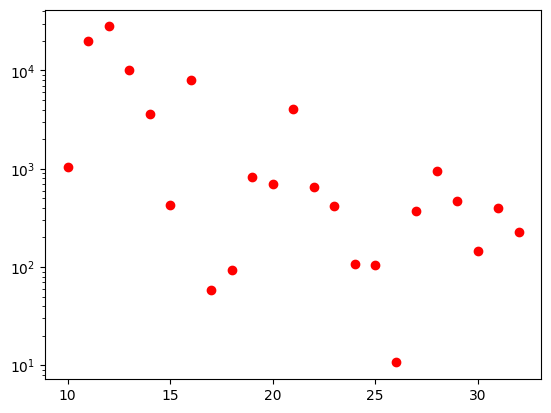

In [53]:
# plot accuracy/covariance as a function of # trials for each Taguchi & BO

inds = range(num_init, num_init + len(avg_covariance))
fig = plt.figure()
ax = plt.subplot(111)
ax.scatter(inds,avg_covariance, c='r')
ax.set_yscale('log')

In [54]:
# Example usage:
ex_param_dicts = [{"z_sh": 7, "z_r2": 80, "g_thickness_h": 4, "p1_offset": 0, "p2_offset": 1, "x_s": 0.0, "x_r2": 0.0, "Cl": 0.0001, "material": "PLA", "lubricant": "None"}, ]
guess_dict = Tag_client.predict(ex_param_dicts)

In [55]:
guess_dict

[{'gear_ratio': (271.7384010714212, 84231.45953450199),
  'Max_torque_gear_ratio_product': (0.08870022723046844, 0.3707807947796552)}]

In [56]:
guess_dict

[{'gear_ratio': (271.7384010714212, 84231.45953450199),
  'Max_torque_gear_ratio_product': (0.08870022723046844, 0.3707807947796552)}]

In [57]:
# initialize BO check
num_init = len(BO_check_client.summarize())
test_trials = BO_check_client.get_next_trials(max_trials=1)
trial = np.max(BO_check_client.summarize()['trial_index'])
BO_check_client.mark_trial_failed(trial_index=trial)

avg_SEM = []
BO_accuracy = []
all_BO_SEM = []
all_BO_acc = []

# solve and record: covariance & accuracy
avg_SEM.append(pred_standard_error(BO_check_client,param_dicts))
BO_accuracy.append(pred_accuracy(BO_check_client, remaining_df))

# for each of the next trials (TAGUCHI)
for ind in range(len(prev_BO_df[np.isfinite(prev_BO_df['max_current'])])):
   
    # add and complete the trial
    add_trials(BO_check_client, prev_BO_df, param_names, choice_bounds, int_bounds, inds = [ind])
    # retrain by get_next_trial(1) 
    test_trials = BO_check_client.get_next_trials(max_trials=1)
    # fail generated trial
    trial = np.max(BO_check_client.summarize()['trial_index'])
    BO_check_client.mark_trial_failed(trial_index=trial)
    # solve and record: covariance & accuracy
    avg_SEM.append(pred_standard_error(BO_check_client,param_dicts))
    BO_accuracy.append(pred_accuracy(BO_check_client, remaining_df))
    all_BO_SEM.append(pred_standard_error(BO_check_client,param_dicts, ret_all=True))
    all_BO_acc.append(pred_accuracy(BO_check_client, remaining_df, ret_all=True))

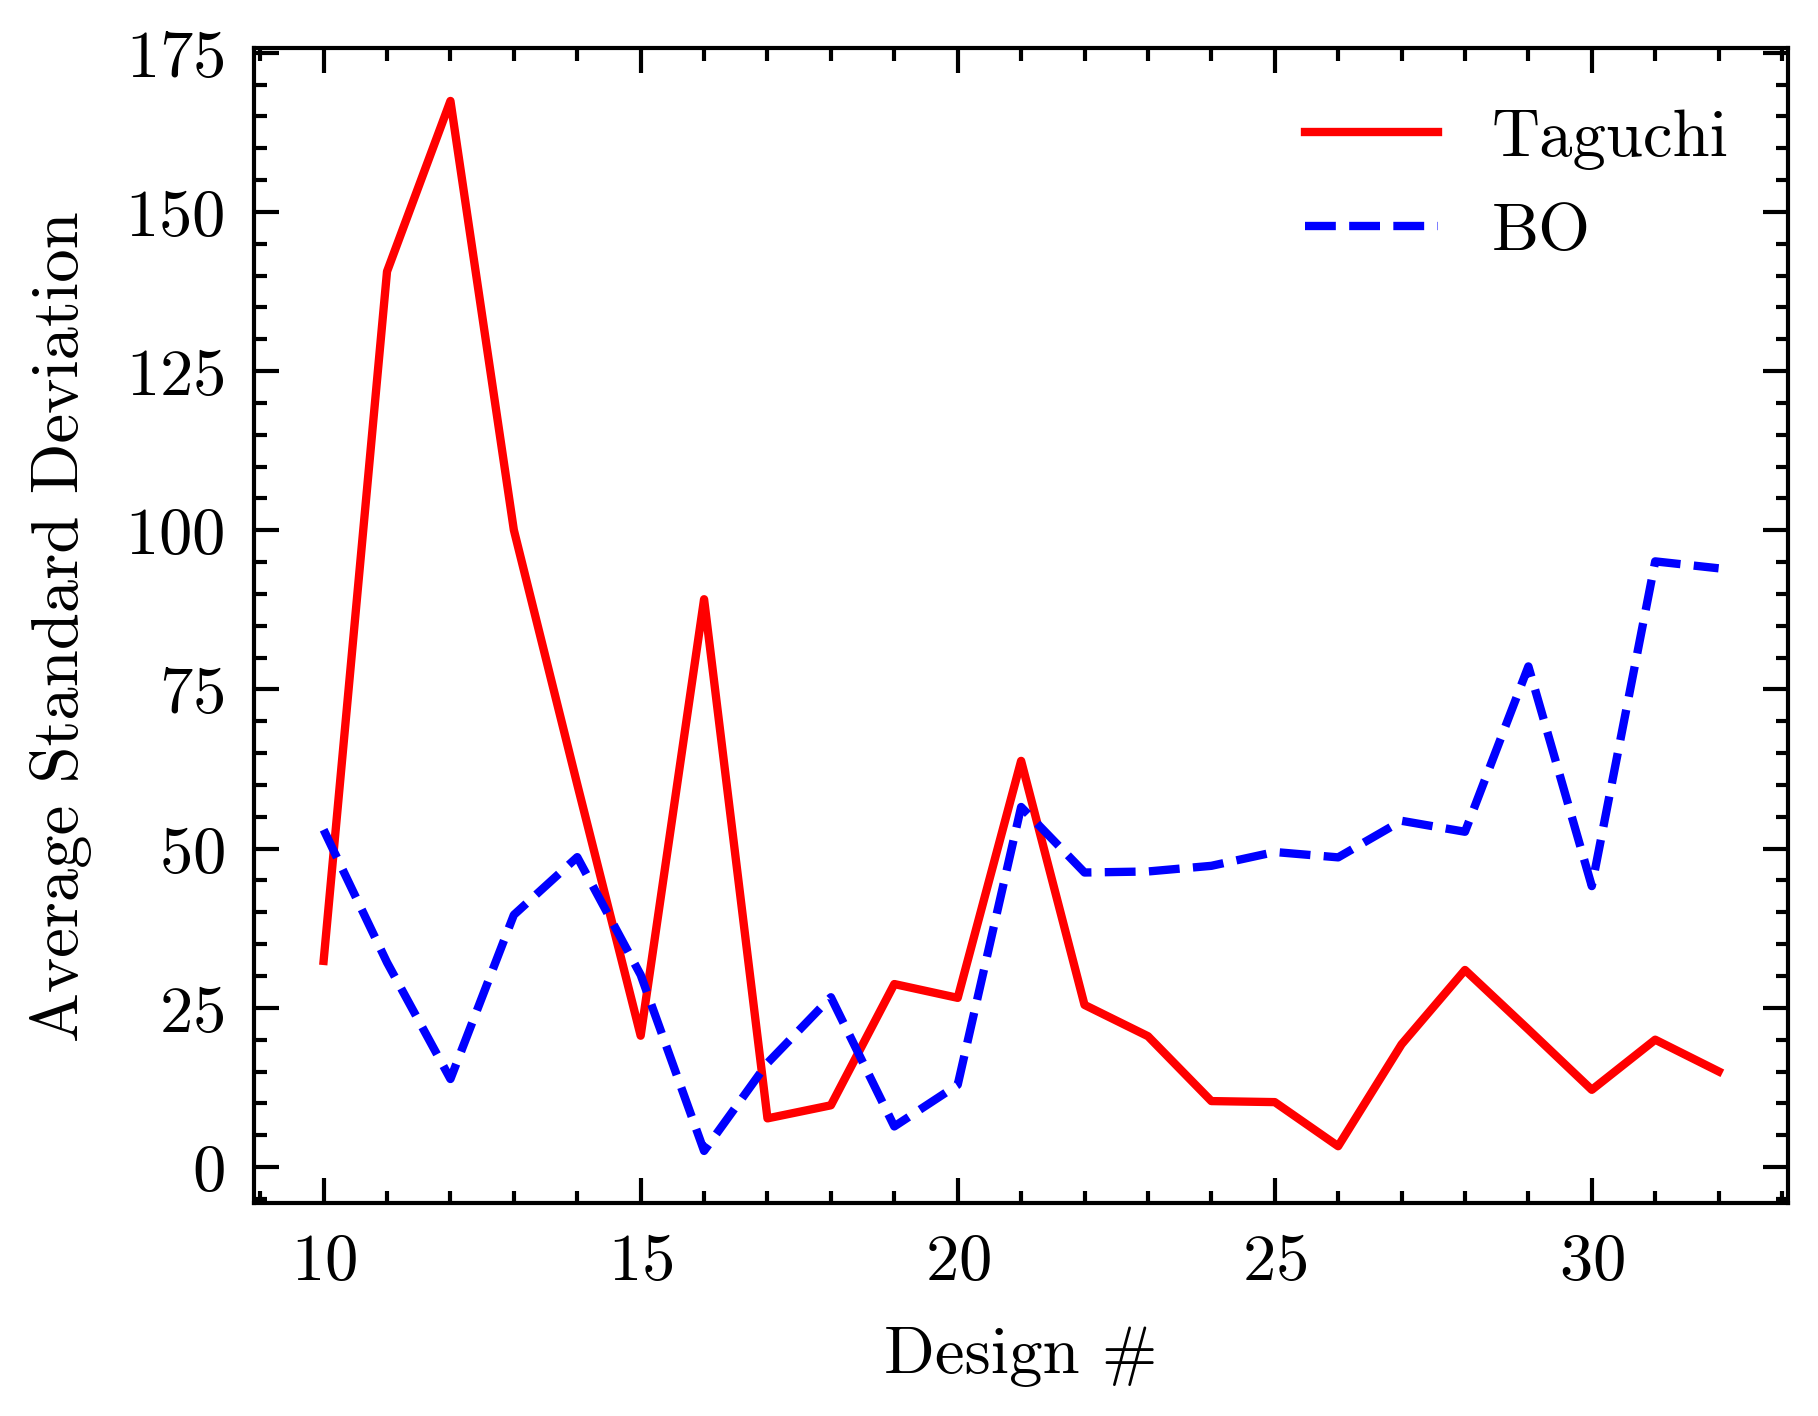

In [58]:
# plot accuracy/covariance as a function of # trials for each Taguchi & BO
with plt.style.context(['science','ieee','no-latex']):
    t_inds = range(num_init, num_init + len(avg_covariance))
    b_inds = range(num_init, num_init + len(prev_BO_df[np.isfinite(prev_BO_df['max_current'])]) + 1)
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(t_inds,np.sqrt(avg_covariance), c='r', label='Taguchi')
    ax.plot(b_inds,np.sqrt(avg_SEM), c='b', label='BO')
    ax.set_xlabel('Design #')
    ax.set_ylabel('Average Standard Deviation')
    # ax.set_yscale('log')
    plt.legend()
    plt.show()

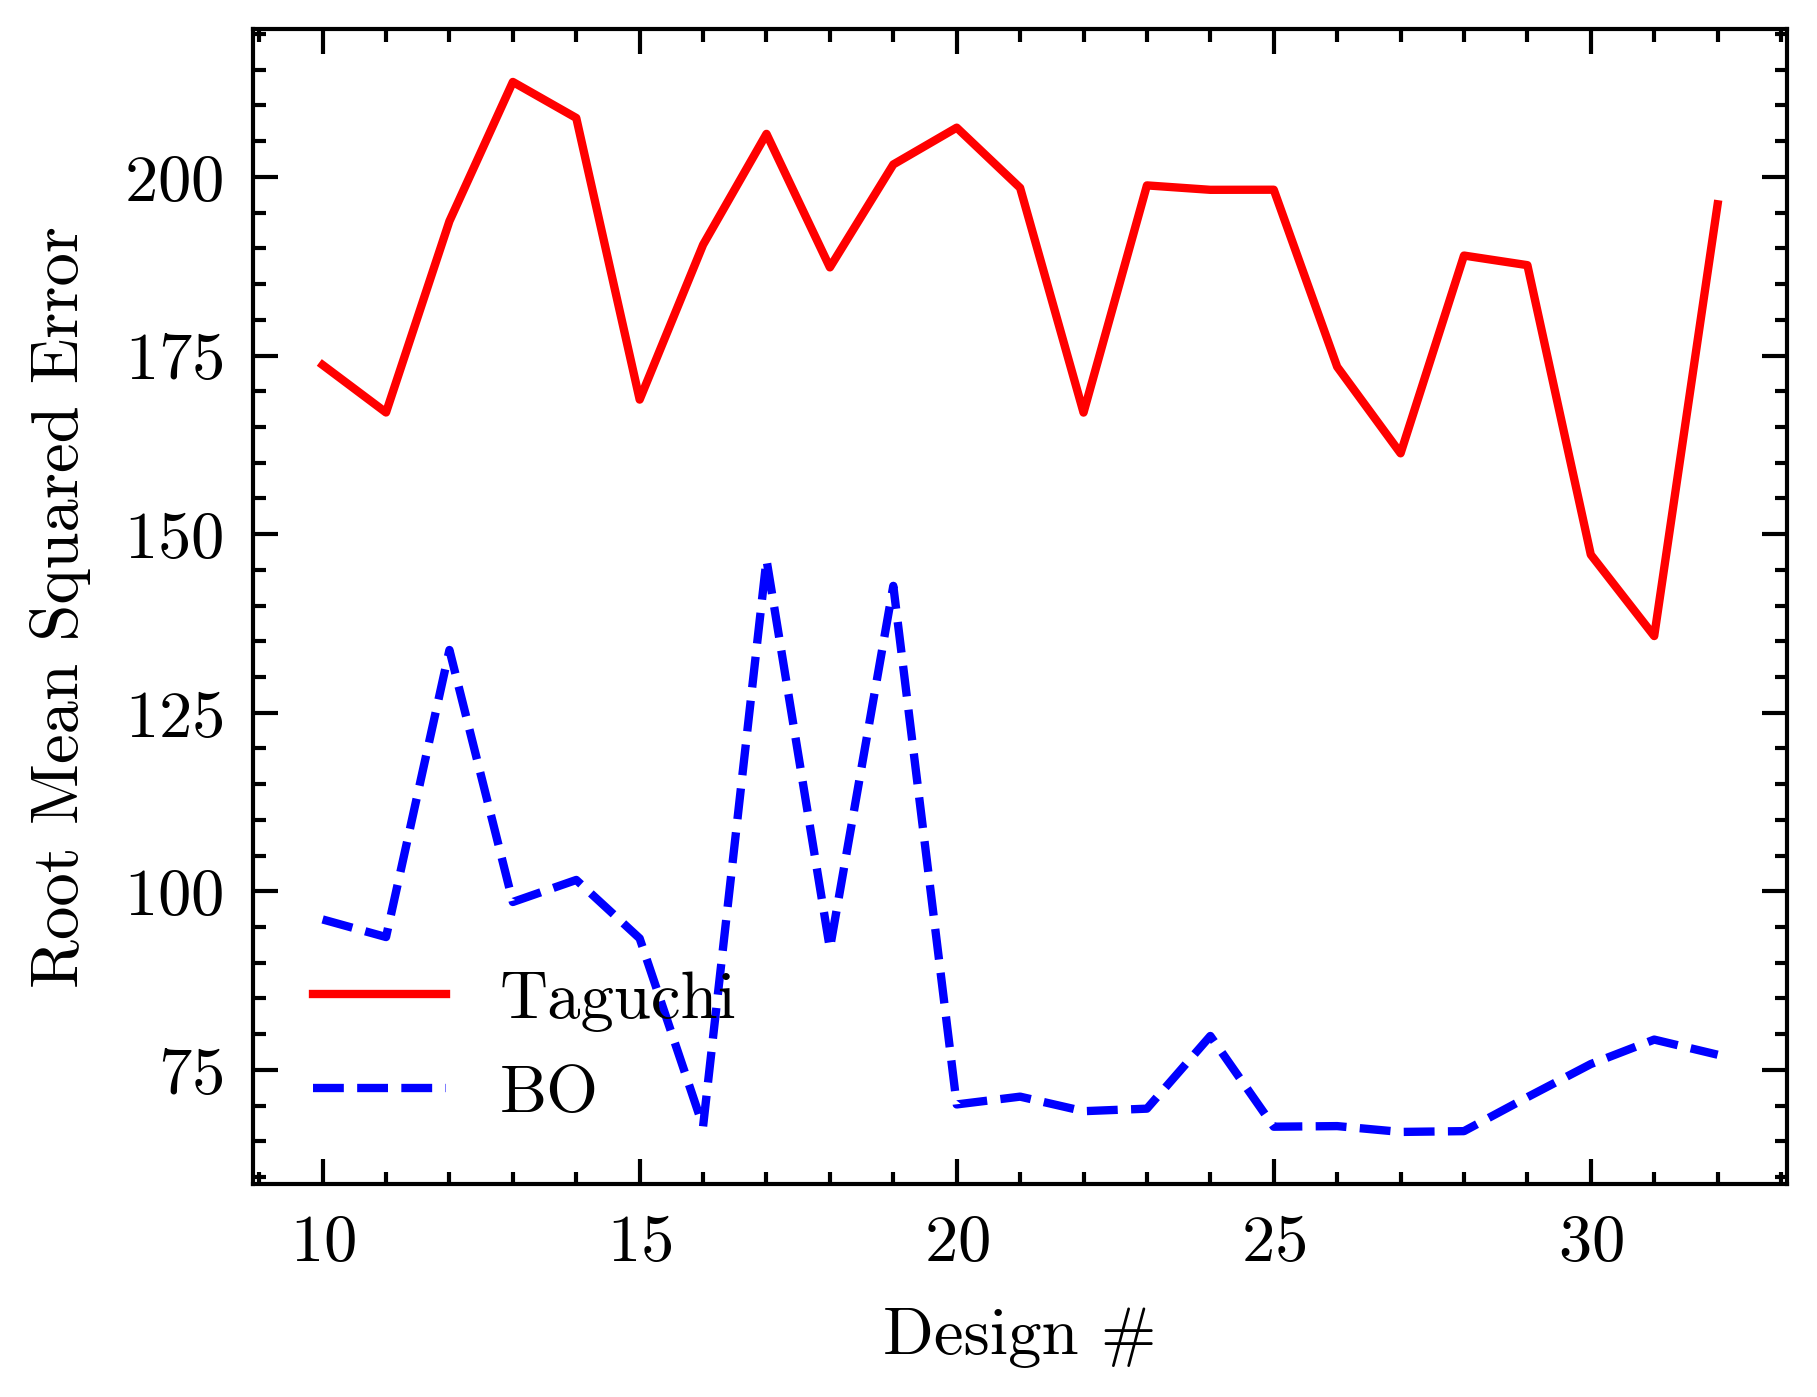

In [59]:
with plt.style.context(['science','ieee','no-latex']):
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(t_inds,tag_accuracy, c='r', label='Taguchi')
    ax.plot(b_inds,BO_accuracy, c='b', label='BO')
    ax.set_xlabel('Design #')
    ax.set_ylabel('Root Mean Squared Error')
    plt.legend()
    plt.show()


In [60]:
pickle.dump(all_BO_acc,open('all_BO_acc_0.3.pkl', 'wb'))
pickle.dump(all_tag_error,open('all_tag_error_0.3.pkl', 'wb'))
pickle.dump(all_BO_SEM,open('all_BO_SEM_0.3.pkl', 'wb'))
pickle.dump(all_tag_SEM,open('all_tag_SEM_0.3.pkl', 'wb'))

In [61]:
# 0.0 - include up until BO outperforms Taguchi (n=40 for uncertainty)
# 0.1 - include up until BO28 (n=40 for uncertainty)
# 0.2 - include up until BO28 (n=1024 for uncertainty)
# 0.3 - include up until BO28 (n=59049 for uncertainty)

### Re-Load and Plot here

In [62]:
all_BO_acc = pickle.load(open('all_BO_acc_0.3.pkl','rb')) # num BO steps x 2 (errors, preds) x num test points (Taguchi)
all_tag_error = pickle.load(open('all_tag_error_0.3.pkl','rb'))
all_BO_SEM = pickle.load(open('all_BO_SEM_0.3.pkl','rb')) # num BO steps x 40 (hypercube size)
all_tag_SEM = pickle.load(open('all_tag_SEM_0.3.pkl','rb'))

In [63]:
bo_errors = [np.sqrt(np.mean(np.array(x[0])**2)) for x in all_BO_acc]  # Get RMSE of first element (errors) from tuple
bo_std = [np.mean([np.sqrt(x['Max_torque_gear_ratio_product'][1]) for x in all_BO_SEM[i]]) for i in range(len(all_BO_SEM))]
tag_errors = [np.sqrt(np.mean(np.array(x[0])**2)) for x in all_tag_error]  # Get RMSE of first element (errors) from tuple
tag_std = [np.mean([np.sqrt(x['Max_torque_gear_ratio_product'][1]) for x in all_tag_SEM[i]]) for i in range(len(all_tag_SEM))]

In [64]:
len([np.sqrt(x['Max_torque_gear_ratio_product'][1]) for x in all_tag_SEM[0]])

10000

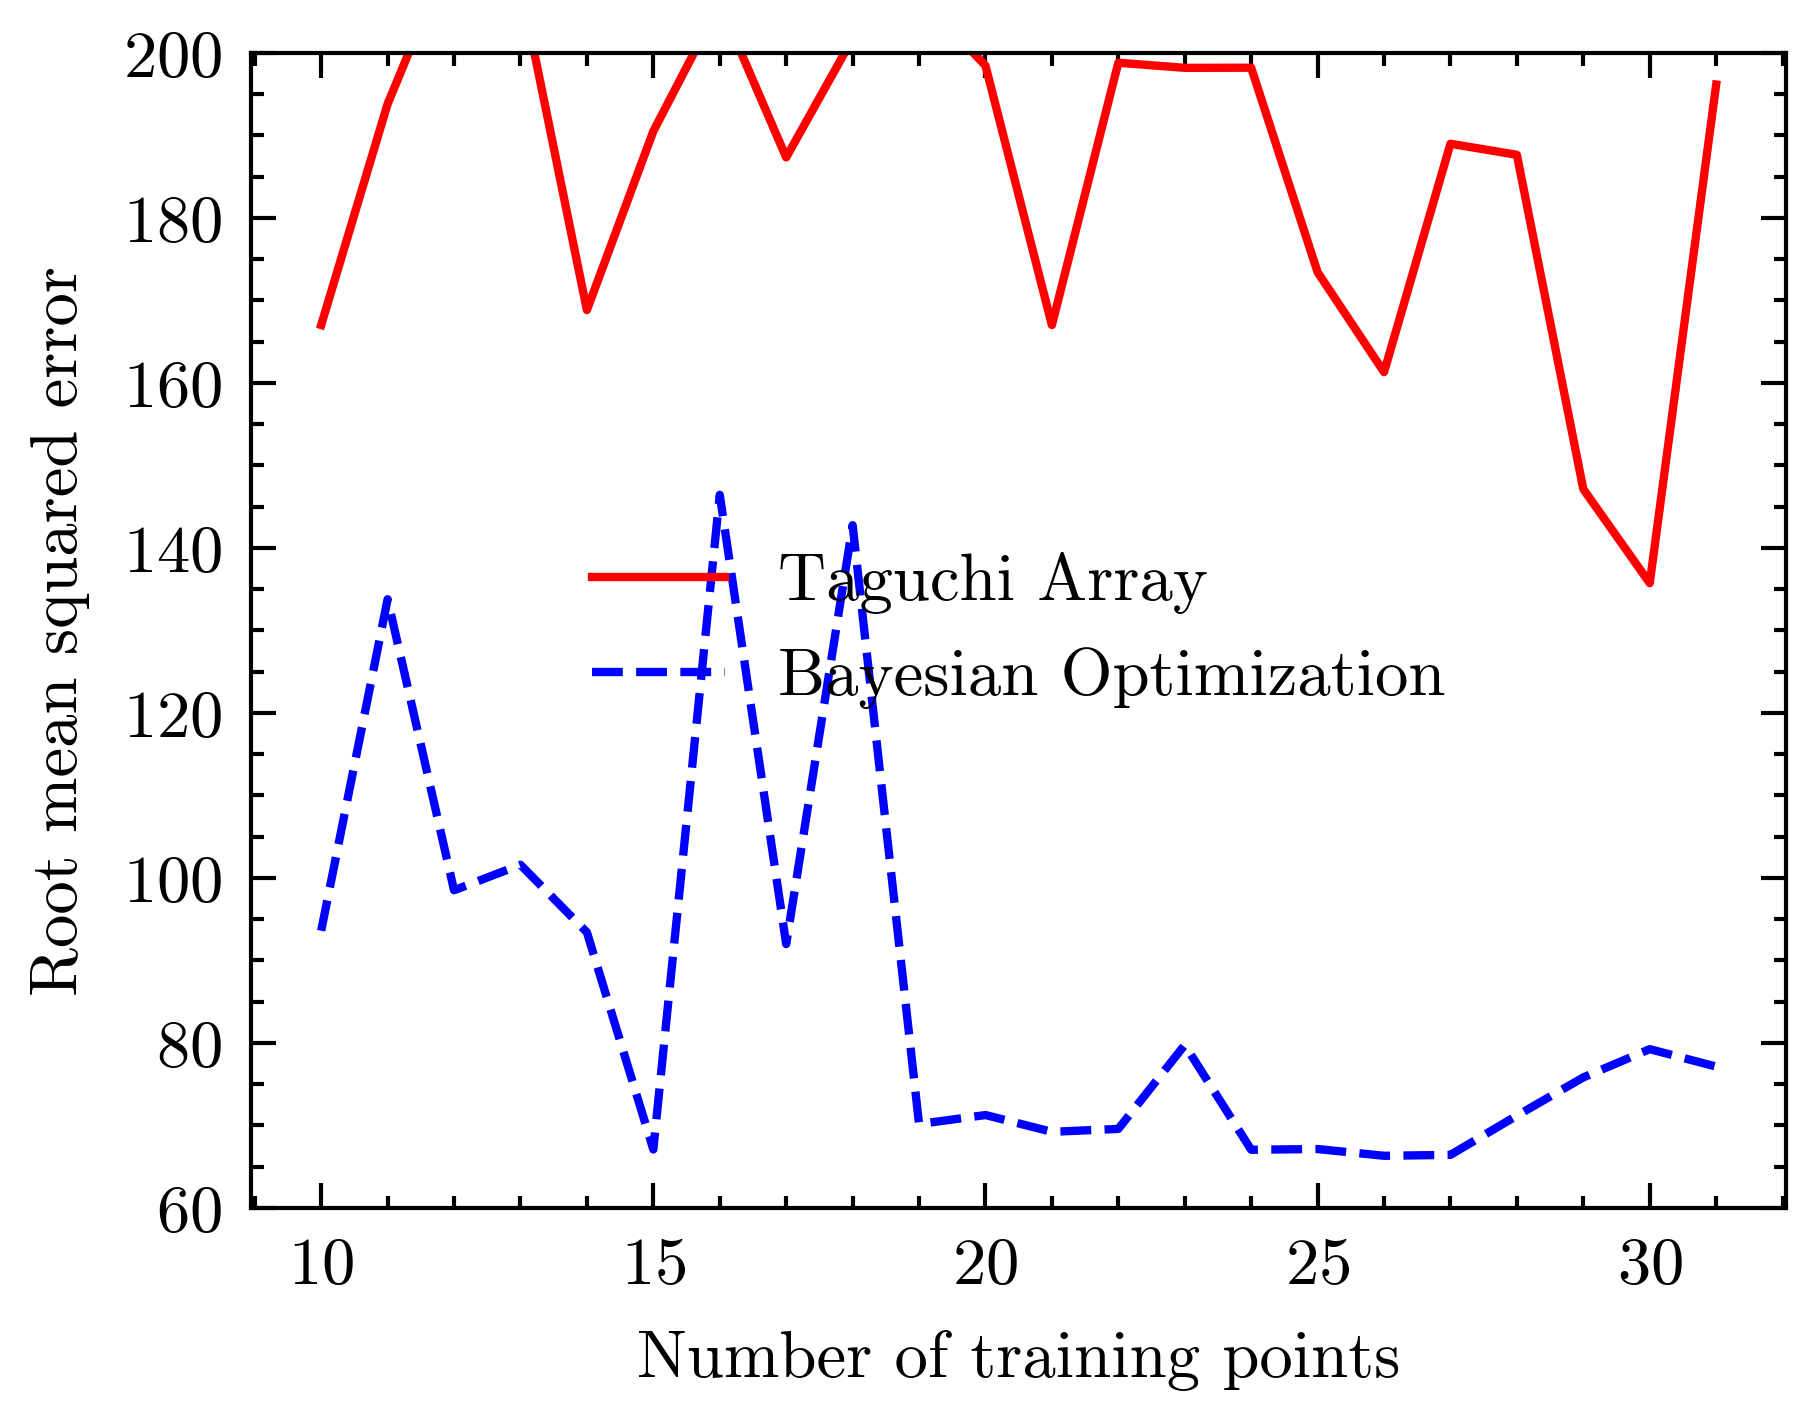

In [65]:
# plot the errors vs. number of trials
with plt.style.context(['science','ieee','no-latex']):
    t_inds = range(num_init, num_init + len(tag_errors))
    b_inds = range(num_init, num_init + len(bo_errors))
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(t_inds,tag_errors, c='r', label='Taguchi Array')
    ax.plot(b_inds,bo_errors, c='b', label='Bayesian Optimization')
    ax.set_xlabel('Number of training points')
    ax.set_ylabel('Root mean squared error')
    ax.set_ylim([60,200])
    plt.legend()
    plt.show()

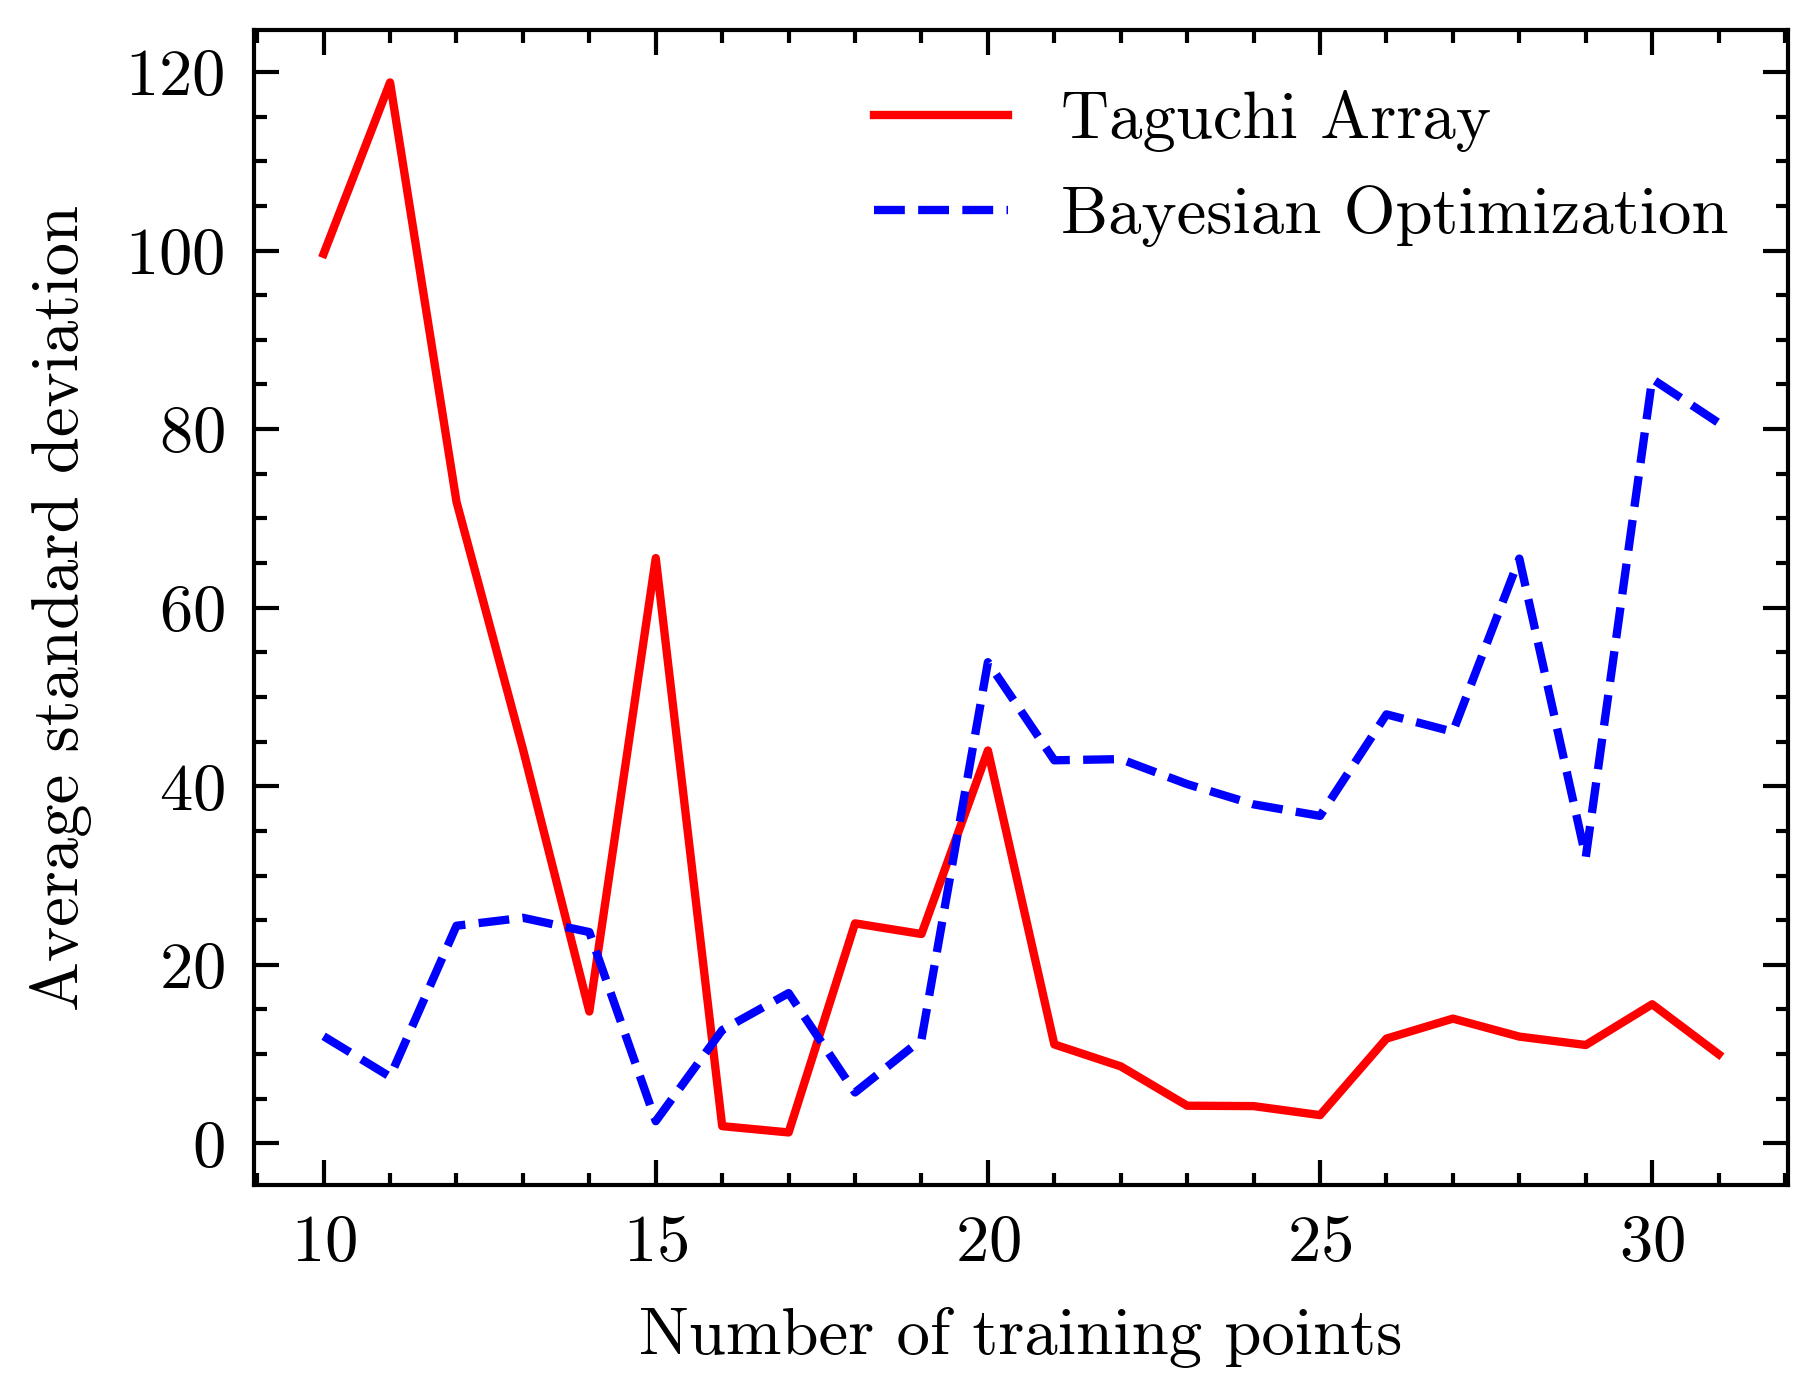

In [66]:
# plot the std vs. number of trials
with plt.style.context(['science','ieee','no-latex']):
    t_inds = range(num_init, num_init + len(tag_std))
    b_inds = range(num_init, num_init + len(bo_std))
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(t_inds,tag_std, c='r', label='Taguchi Array')
    ax.plot(b_inds,bo_std, c='b', label='Bayesian Optimization')
    ax.set_xlabel('Number of training points')
    ax.set_ylabel('Average standard deviation')
    plt.legend()
    plt.show()

In [67]:
bo_errors[0]

93.60082991841651

## See how std reacts to the inclusion of all points

In [68]:
Omnipotent_client.get_next_trials(max_trials=1)

{55: {'z_sh': 6,
  'z_r2': 83,
  'g_thickness_h': 5,
  'p1_offset': 2,
  'p2_offset': 2,
  'x_s': -0.15330516248941417,
  'x_r2': 0.611979446386856,
  'Cl': 0.00028827802828533864,
  'material': 'ABS',
  'lubricant': 'Oil'}}

In [69]:
# get std for Omnipotent client

omn_std_dict = pred_standard_error(Omnipotent_client, param_dicts, ret_all=True)
omn_stds = [np.sqrt(x['Max_torque_gear_ratio_product'][1]) for x in omn_std_dict]
omn_std = np.mean(omn_stds)

In [70]:
len(omn_stds)

10000

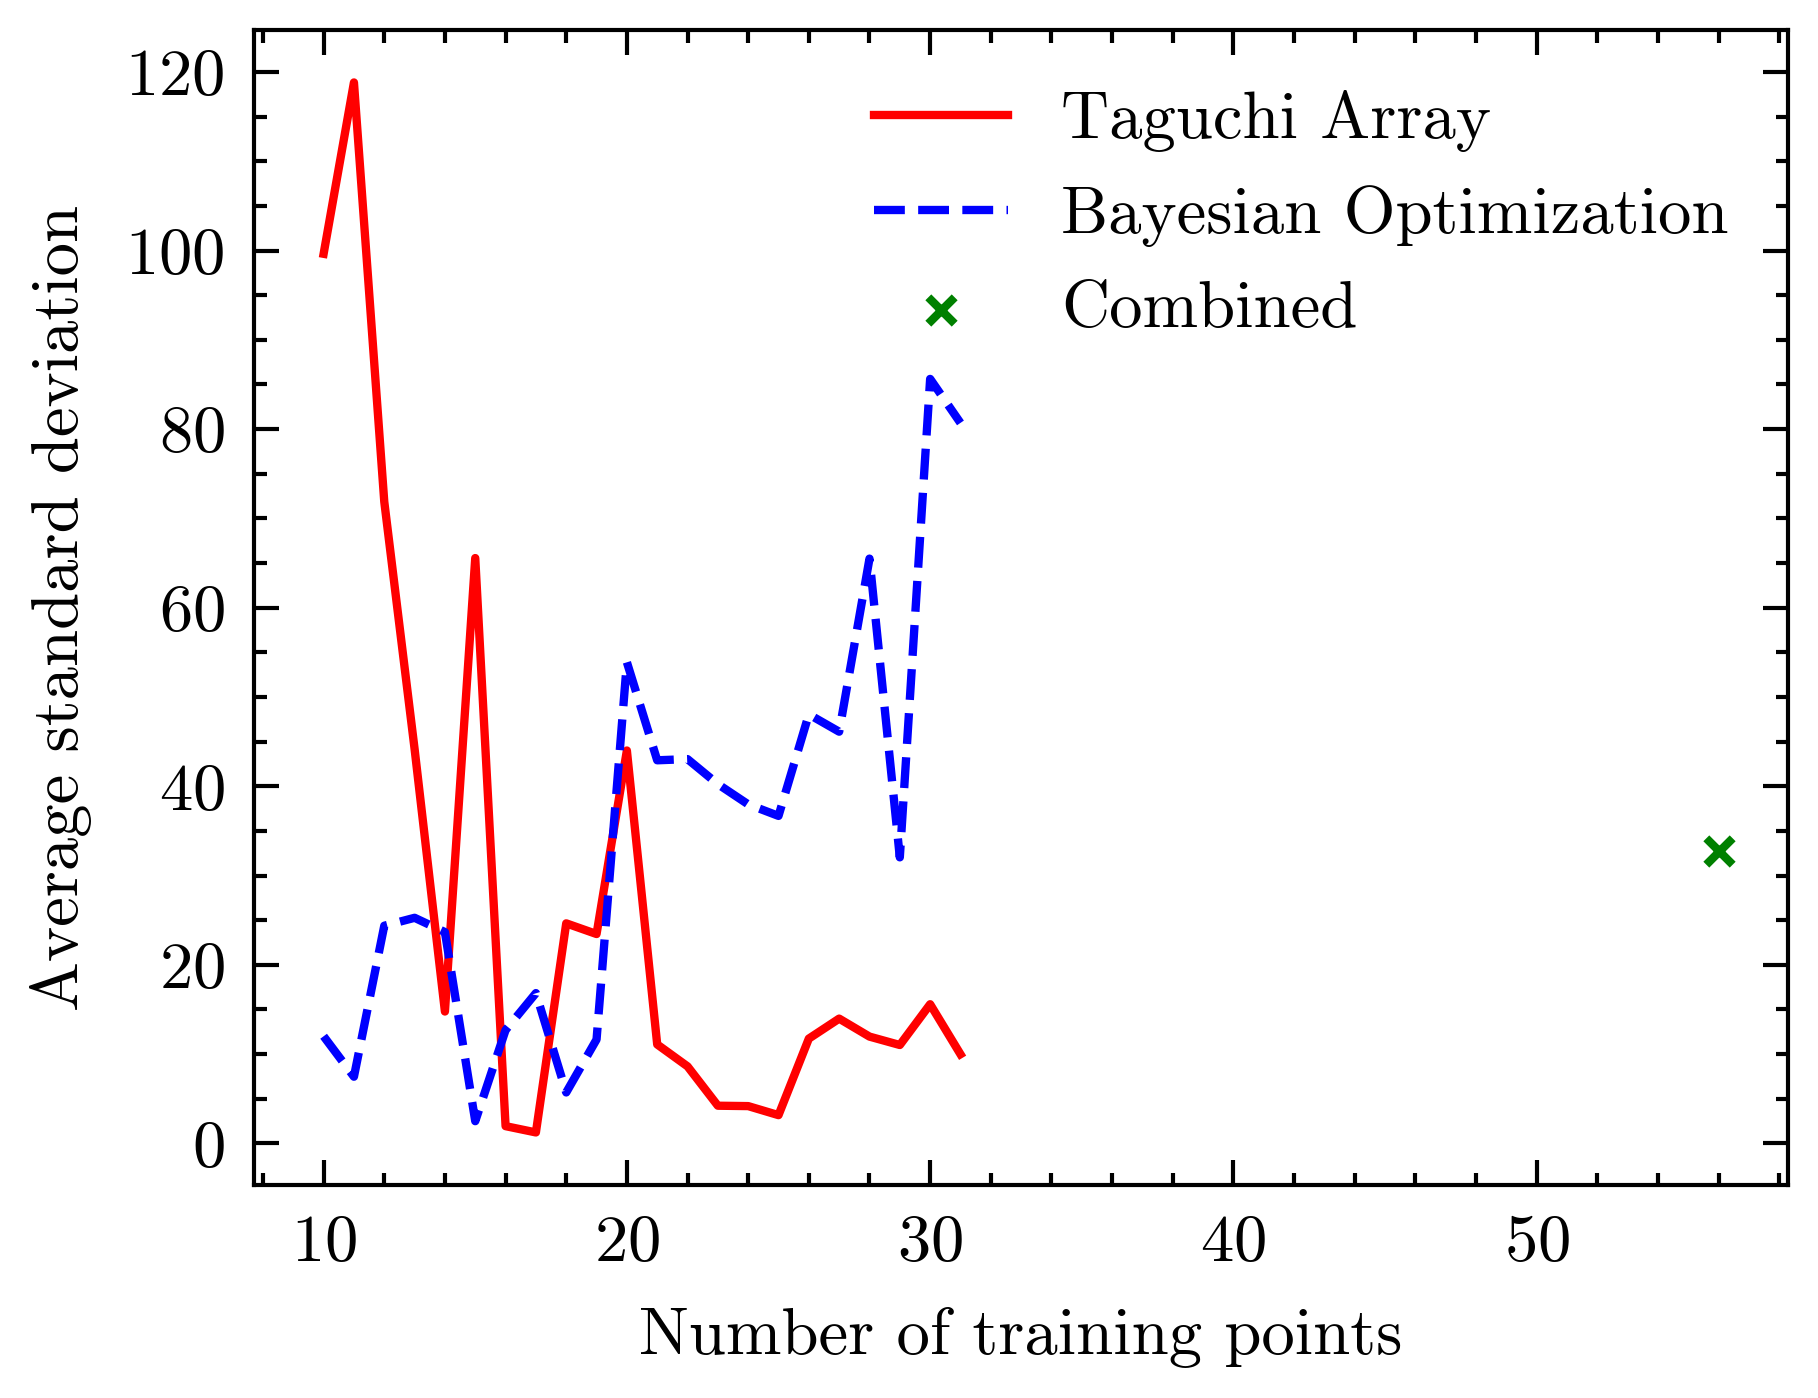

In [71]:
# plot the std vs. number of trials
bo_errors = [np.sqrt(np.mean(np.array(x[0])**2)) for x in all_BO_acc]  # Get mean of first element (errors) from tuple
bo_std = [np.mean([np.sqrt(x['Max_torque_gear_ratio_product'][1]) for x in all_BO_SEM[i]]) for i in range(len(all_BO_SEM))]
tag_errors = [np.mean(x[0]) for x in all_tag_error]  # Get mean of first element (errors) from tuple
tag_std = [np.mean([np.sqrt(x['Max_torque_gear_ratio_product'][1]) for x in all_tag_SEM[i]]) for i in range(len(all_tag_SEM))]

with plt.style.context(['science','ieee','no-latex']):
    t_inds = range(num_init, num_init + len(tag_std))
    b_inds = range(num_init, num_init + len(bo_std))
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(t_inds,tag_std, c='r', label='Taguchi Array')
    ax.plot(b_inds,bo_std, c='b', label='Bayesian Optimization')
    ax.scatter(len(Omnipotent_client.summarize()), omn_std, c='g', label='Combined', marker='x', s=10)
    ax.set_xlabel('Number of training points')
    ax.set_ylabel('Average standard deviation')
    plt.legend()
    plt.show()